In [435]:
import matplotlib.pyplot as plt  # 繪圖套件
import numpy as np  # 數值運算套件
from PIL import Image  # 圖片處理套件
import pathlib  # 路徑處理套件
import cv2  # OpenCV 影像處理套件

# PyTorch 相關套件
import torch  # PyTorch 主套件
from torchvision import transforms  # 資料轉換工具
from torchvision.models import vgg16  # VGG-16 模型

# fastai 相關套件
from fastai.vision.learner import load_learner
from fastai.data.external import *
from fastai.vision.widgets import *
from fastbook import *
import fastbook
fastbook.setup_book()

# PyTorch Grad-CAM 套件
from pytorch_grad_cam import GradCAM  # 匯入 Grad-CAM 模組
from pytorch_grad_cam.utils.image import show_cam_on_image  # 顯示圖片與 CAM 的工具
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget  # 分類器輸出目標

In [436]:
def get_x(r): return
def get_y(r): return

In [437]:
# 載入模型
system_platform = platform.system()  # 系統路徑問題和呼叫模型有關
if system_platform != 'Windows':
    pathlib.WindowsPath = pathlib.PosixPath
learn = torch.load('model.pt', map_location='cpu')
print(learn.model[0][7][2].conv2)
# 提取目標卷積層
target_layers = [learn.model[0][7][2].conv2]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [438]:
ndir_images = os.listdir('origin_image')
ndir_images = [image for image in ndir_images if image.endswith('.jpg')]
ndir_images.sort()
ndir_images

['input1.jpg',
 'input11.jpg',
 'input12.jpg',
 'input3.jpg',
 'input4.jpg',
 'input6.jpg',
 'input7.jpg',
 'input8.jpg',
 'input9.jpg']

(3120, 3120)


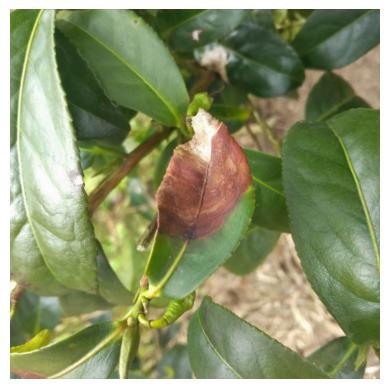

In [439]:
# 載入測試圖像與遮罩
# 1、6、9
img_path = './origin_image/input1.jpg' 
mask_path = './mask_image/input_mask1.png'
img = Image.open(img_path)
print(img.shape)
# 顯示原始圖像
plt.imshow(img)
plt.axis('off')
plt.show()
ORIGIANL_SIZE = img.shape

(1, 512, 512)
(512, 512)


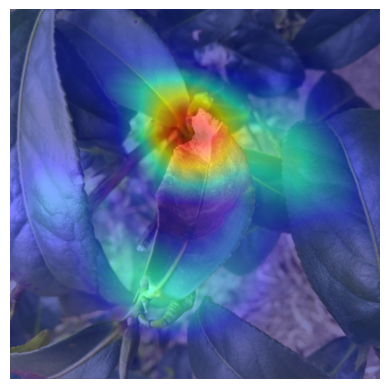

In [440]:
# img = Image.open('origin_image/' + ndir_images[0])
# 提取 Grad-CAM
# 資料前處理
# IMAGE_SIZE = 512 # 9
IMAGE_SIZE = 512 # 1
# IMAGE_SIZE = 180 # 6
img = Image.open(img_path)
img = np.float32(img.resize((IMAGE_SIZE, IMAGE_SIZE))) / 255.

transform = transforms.ToTensor()
input_tensor = transform(img).unsqueeze(0)

 # GradCAM 輸入模型、可視化目標層
gradcam = GradCAM(model=learn.model, target_layers=target_layers)
# 使用 cam 取得熱力圖
print(gradcam(input_tensor=input_tensor).shape)
grayscale_cam = gradcam(input_tensor=input_tensor)[0, :, :]
print(grayscale_cam.shape)
# 將熱力圖和原圖交疊
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.axis('off')
plt.imshow(cam_image)
plt.show()

In [441]:
grayscale_cam

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00581802, 0.00581802, 0.00581802],
       [0.        , 0.        , 0.        , ..., 0.00581802, 0.00581802, 0.00581802],
       [0.        , 0.        , 0.        , ..., 0.00581802, 0.00581802, 0.00581802]], dtype=float32)

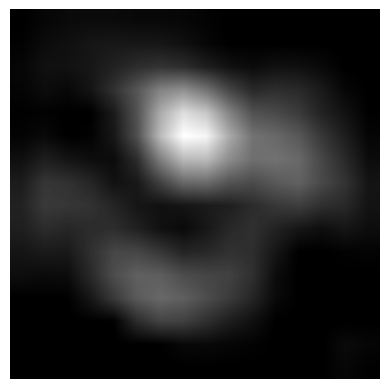

In [442]:
# 原始熱力圖灰度圖
plt.imshow(grayscale_cam, cmap='gray')
plt.axis('off')
plt.show()

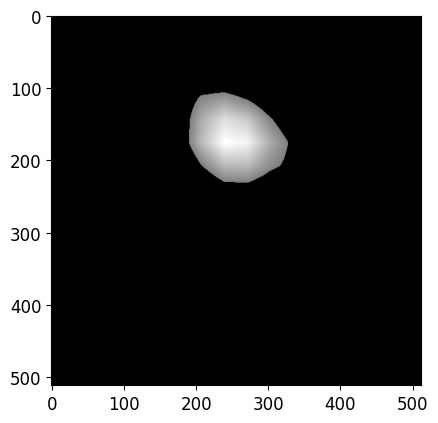

In [443]:
# 複製一份灰度圖
thresholded_grayscale_cam = grayscale_cam.copy()
# 將不足 < 閾值（關注度不高的區域）的像素設置為 0
thresholded_grayscale_cam[thresholded_grayscale_cam < 0.5] = 0
# 顯示閾值處理後的熱力圖
plt.imshow(thresholded_grayscale_cam, cmap='gray')
plt.show()

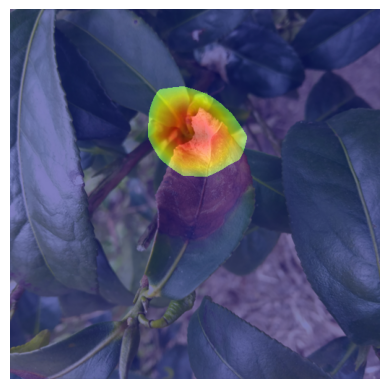

In [444]:
# 將熱力圖貼回原始圖像
visualization = show_cam_on_image(img, thresholded_grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.axis('off')
plt.show()

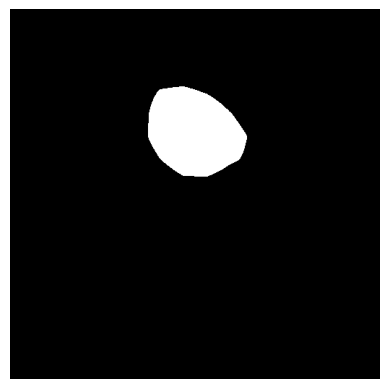

In [445]:
# 處理後的熱力圖二值化
binary_cam = (grayscale_cam > 0.5).astype(np.uint8)
plt.imshow(binary_cam, cmap='gray')
plt.axis('off')
plt.show()

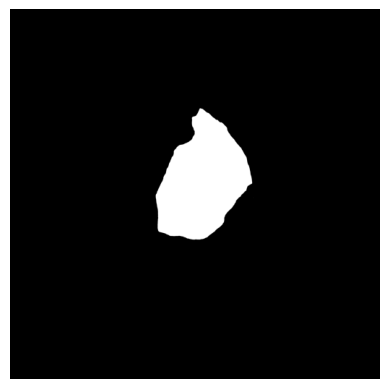

In [446]:
# 載入 SAM 真實 mask
real_binary_cam = Image.open(mask_path)
real_binary_cam = np.array(real_binary_cam.resize((IMAGE_SIZE, IMAGE_SIZE))) / 255.0
plt.imshow(real_binary_cam, cmap='gray')
plt.axis('off')
plt.show()

In [447]:
# 計算 IoU
def calculate_iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    
    # 計算交集
    intersection = np.logical_and(mask1, mask2)
    
    # 計算聯集
    union = np.logical_or(mask1, mask2)
    
    # 計算 IoU
    iou = np.sum(intersection) / np.sum(union)
    
    return iou

In [448]:
# 假设 mask1 和 mask2 是您的两个二值化结果
iou_score = calculate_iou(real_binary_cam, binary_cam)

print(f"IoU 分數: {iou_score:.4f}")

IoU 分數: 0.2518


In [449]:
import os
import shutil

# 計算應該歸類到哪個區間
# 使用floor division將分數除以0.05後乘以0.05得到區間下限
folder_base = (iou_score // 0.05) * 0.05

# 計算區間的上限
folder_top = folder_base + 0.05
folder = f'{folder_base:.2f}-{folder_top:.2f}'
print(f'分數 {iou_score} 放在 {folder} 的資料夾')

分數 0.25175071570138735 放在 0.25-0.30 的資料夾


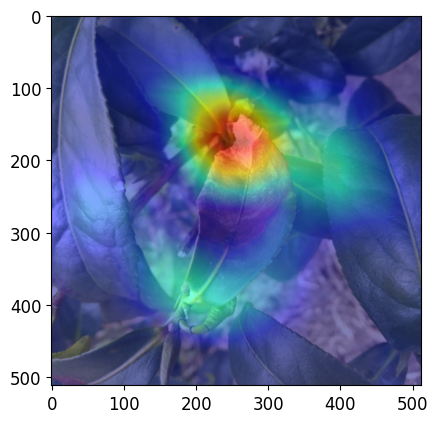

In [450]:
plt.imshow(cam_image)

In [451]:
ORIGIANL_SIZE

(3120, 3120)

In [452]:
save_path = f'./result/{folder}'
os.makedirs(f'./result/{folder}', exist_ok=True)

In [453]:
# numpy array 轉 PIL
pil_cam_image = Image.fromarray(np.uint8(cam_image))

# resize
pil_cam_image = pil_cam_image.resize((ORIGIANL_SIZE[1], ORIGIANL_SIZE[0]), Image.LANCZOS)

# 轉回 numpy array
pil_cam_image.save(f'{save_path}/input_cam1.jpg')

In [454]:
# numpy array 轉 PIL
pil_cam_image = Image.fromarray(np.uint8(visualization))

# resize
pil_cam_image = pil_cam_image.resize((ORIGIANL_SIZE[1], ORIGIANL_SIZE[0]), Image.LANCZOS)

# 轉回 numpy array
pil_cam_image.save(f'{save_path}/visualization1.jpg')

In [455]:
# numpy array 轉 PIL
pil_cam_image = Image.fromarray(np.uint8(binary_cam*255.))

# resize
pil_cam_image = pil_cam_image.resize((ORIGIANL_SIZE[1], ORIGIANL_SIZE[0]), Image.LANCZOS)

# 轉回 numpy array
pil_cam_image.save(f'{save_path}/binary_cam1.jpg')

In [456]:
shutil.copy(img_path, save_path)
shutil.copy(mask_path, save_path)

'./result/0.25-0.30/input_mask1.png'